In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('datasets/combined.csv')
num = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit']
cate = ['Term', 'Years in current job', 'Home Ownership', 'Purpose', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens']
target = 'Loan Status'

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Scaling numerical data to a normal distribution
scaler = StandardScaler()
data[num] = scaler.fit_transform(data[num])

#One-Hot Encoding categorical data
ohe = OneHotEncoder(sparse=False)
ohe_data = ohe.fit_transform(data[cate])
feature_names = ohe.get_feature_names_out(cate)
ohe_df = pd.DataFrame(ohe_data, columns=feature_names)

#combining numerical and categorical data into a single dataframe
pred = pd.concat([data[num], ohe_df], axis=1)
pred.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Current Credit Balance,Maximum Open Credit,Term_Long Term,Term_Short Term,...,Purpose_Small Business,Purpose_Take a Trip,Purpose_Vacation,Purpose_Wedding,Number of Credit Problems_0,Number of Credit Problems_>= 1,Bankruptcies_0,Bankruptcies_>= 1,Tax Liens_0,Tax Liens_>= 1
0,0.785256,-0.287916,-0.206719,-1.130710,-0.075000,-1.023820,-0.109559,-0.319168,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.240210,0.136230,-0.648519,-0.816379,-0.856869,-0.397137,0.035061,-0.407626,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.484801,0.454339,-0.186254,-0.628059,0.285862,0.438441,-0.654448,-0.748851,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.361462,-1.383625,1.498528,0.067518,0.736940,-1.441609,0.964498,0.091505,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.494247,0.772448,0.145259,1.904886,-0.571186,1.900703,2.158861,1.476592,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pred,
    data['Loan Status'],
    test_size=0.25,
    random_state=42
)

## Neural Network
We created a model with an input layer (ReLU activation), 2 hidden layers (ReLU activation), and an output layer (Sigmoid activation) that uses iterative learning, assigning and training weights to predict the correct class labels of input variables. It learns and classifies both our numerical and categorical data to analyse correlations.

In [5]:
def create_model(hidden_layer_units, input_dim, dropout=False, dropout_rate=0.2, model_name='model'):
    """
    Creates a neural network classifier model with:
        - l hidden layers, where l is len(hidden_layer_units)
        - hidden_layer_units[i] units for i'th layer
        - Binary Crossentropy loss
        - Adam optimizer
        - Accuracy, precision, and recall metrics
        - Dropout in each layer (optional)
        - Model name model_name
    
    Returns the compiled model.
    """
    
    model = Sequential(name=model_name)
    
    # Input layer
    model.add(Dense(hidden_layer_units[0], 
                    activation='relu', 
                    input_dim=input_dim,
                    name='Dense_1'))
    
    if dropout == True:
        model.add(Dropout(dropout_rate, name='Dropout_1'))    
    
   # Add the hidden layers
    l = 2
    for units in hidden_layer_units[1:]:
        model.add(Dense(units, activation='relu', name=f'Dense_{l}'))
        l += 1
        
        if dropout == True:
            model.add(Dropout(dropout_rate, name=f'Dropout_{l}'))
    
    # Output layer (sigmoid outputs [0, 1])
    model.add(Dense(1, activation='sigmoid', name='Output'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model


def visualize_performance(y_train, y_train_pred, y_test, y_test_pred):
    """
    Creates a confusion matrix visualization for train and test set
    using heatmap with added information such as:
        - Accuracy
        - Precision
        - Recall
        - F1 score
        
    Returns the accuracy, precision, recall, and F1 score from test set.
    """
    
    f, ax = plt.subplots(ncols=2, figsize=(14, 4))
    f.suptitle('Training vs Test Performance', fontweight='bold', fontsize='x-large')
    
    # Training set
    cf_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cf_train, fmt='.0f', annot=True, ax=ax[0])
    
    # Calculate metrics
    accuracy_train = np.trace(cf_train) / float(np.sum(cf_train))
    precision_train = cf_train[1,1] / sum(cf_train[:,1])
    recall_train = cf_train[1,1] / sum(cf_train[1,:])
    f1_score_train = 2 * precision_train * recall_train / (precision_train + recall_train)
    
    stats_text_train = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy_train, precision_train, recall_train, f1_score_train)
    
    ax[0].set(xlabel='Predicted' + stats_text_train, 
              ylabel='Actual', title='Training Performance')
    
    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cf_test, fmt='.0f', annot=True, ax=ax[1])
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    stats_text_test = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy_test, precision_test, recall_test, f1_score_test)
    
    ax[1].set(xlabel='Predicted' + stats_text_test, 
              ylabel='Actual', title='Test Performance')
    
    plt.show()
    
    return accuracy_test, precision_test, recall_test, f1_score_test


def test_performance(y_test, y_test_pred):
    """ 
    Returns the accuracy, precision, recall, and F1 score from test set.
    """

    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    return accuracy_test, precision_test, recall_test, f1_score_test


def visualize_training_history(history):
    """
    Creates a visualization of model's training process that contains:
        - Loss
        - Accuracy
        - Precision
        - Recall
    """
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
    ax[0][0].plot(history.history['loss'], label='Loss (training data)')
    ax[0][0].set_title('Loss History')
    ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][0].legend(loc="upper right")

    ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
    ax[0][1].set_title('Accuracy History')
    ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][1].legend(loc="lower right")    
    
    ax[1][0].plot(history.history['precision'], label='Precision (training data)')
    ax[1][0].set_title('Precision History')
    ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][0].legend(loc="lower right")
        
    ax[1][1].plot(history.history['recall'], label='Recall (training data)')
    ax[1][1].set_title('Recall History')
    ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][1].legend(loc="lower right")

def standardize(X_train, X_test):
    """
    Standardize the inputs of the train and test set.
    
    Returns the standardized inputs.
    """
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    return X_train_std, X_test_std


In [6]:
# To store training histories of different resampling methods
training_histories = {}
tests_performance = {'Test Accuracy': [], 
                     'Test Precision': [], 
                     'Test Recall': [], 
                     'Test F1 Score': []}

In [7]:
X_train, X_test = standardize(X_train, X_test)

Summary of our Neural Network model:

In [8]:
model = create_model([46, 46, 46], input_dim=len(X_train[0]), model_name='original-model')
model.summary()

Model: "original-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                      │ (None, 46)                  │           2,162 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 46)                  │           2,162 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_3 (Dense)                      │ (None, 46)                  │           2,162 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              47 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,533 (25.52 KB)

 Trainable params: 6,533 (25.52 KB)

 Non-trainable params: 0 (0.00 B)

Training process of Neural Network:

In [9]:
history = model.fit(X_train, y_train, batch_size=32, epochs=200)

# Save training history
training_histories['Original'] = history

Epoch 1/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7551 - loss: 0.5459 - precision: 0.7644 - recall: 0.9826
Epoch 2/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7656 - loss: 0.5230 - precision: 0.7659 - recall: 0.9992
Epoch 3/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7683 - loss: 0.5177 - precision: 0.7689 - recall: 0.9978
Epoch 4/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7654 - loss: 0.5178 - precision: 0.7665 - recall: 0.9969
Epoch 5/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7698 - loss: 0.5121 - precision: 0.7721 - recall: 0.9936
Epoch 6/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7696 - loss: 0.5114 - precision: 0.7725 - recall: 0.9920
Epoch 7/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7708 - loss: 0.5120 - precision: 0.7738 - recall: 0.9903
Epoch 8/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7698 - loss: 0.5089 - precision: 0.7741 - recall:

1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8300 - loss: 0.3866 - precision: 0.8428 - recall: 0.9556
Epoch 102/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8275 - loss: 0.3887 - precision: 0.8397 - recall: 0.9575
Epoch 103/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8293 - loss: 0.3826 - precision: 0.8428 - recall: 0.9555
Epoch 104/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8338 - loss: 0.3794 - precision: 0.8449 - recall: 0.9605
Epoch 105/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8307 - loss: 0.3810 - precision: 0.8444 - recall: 0.9561
Epoch 106/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8305 - loss: 0.3832 - precision: 0.8448 - recall: 0.9549
Epoch 107/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8278 - loss: 0.3832 - precision: 0.8420 - recall: 0.9551
Epoch 108/200
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8314 - loss: 0.3795 - precision: 0.8439 - recal

Weights of individual layers:

In [19]:
#Dense 1

weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Weights for Dense 1:")
for f in range(X_train.shape[1]):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Weights for Dense 1:
1.Years in current job_6 years (0.3216)
2.Years of Credit History (0.3340)
3.Number of Open Accounts (0.3403)
4.Maximum Open Credit (0.3418)
5.Purpose_Business Loan (0.3428)
6.Purpose_Take a Trip (0.3445)
7.Home Ownership_Home Mortgage (0.3446)
8.Purpose_Educational Expenses (0.3479)
9.Purpose_Vacation (0.3480)
10.Term_Short Term (0.3505)
11.Annual Income (0.3513)
12.Credit Score (0.3521)
13.Years in current job_10+ years (0.3591)
14.Years in current job_3 years (0.3592)
15.Home Ownership_Own Home (0.3593)
16.Purpose_Renewable Energy (0.3600)
17.Current Loan Amount (0.3605)
18.Purpose_Small Business (0.3622)
19.Purpose_Other (0.3641)
20.Term_Long Term (0.3651)
21.Purpose_Buy House (0.3660)
22.Purpose_Major Purchase (0.3668)
23.Purpose_Moving (0.3671)
24.Home Ownership_Have Mortgage (0.3694)
25.Current Credit Balance (0.3769)
26.Number of Credit Problems_>= 1 (0.3809)
27.Monthly Debt (0.3817)
28.Tax Liens_>= 1 (0.3824)
29.Number of Credit Problems_0 (0.3828)
30.Year

In [18]:
#Dense 2

weights = np.abs(model.layers[1].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Weights for Dense 2:")
for f in range(X_train.shape[1]):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Weights for Dense 2:
1.Number of Open Accounts (0.1338)
2.Home Ownership_Home Mortgage (0.3275)
3.Years in current job_10+ years (0.3291)
4.Years in current job_3 years (0.3342)
5.Monthly Debt (0.3387)
6.Years in current job_5 years (0.3399)
7.Years in current job_1 year (0.3494)
8.Current Loan Amount (0.3566)
9.Annual Income (0.3608)
10.Home Ownership_Own Home (0.3774)
11.Purpose_Other (0.3780)
12.Purpose_Business Loan (0.3800)
13.Years in current job_6 years (0.3804)
14.Home Ownership_Have Mortgage (0.3862)
15.Years in current job_7 years (0.3872)
16.Number of Credit Problems_0 (0.3875)
17.Purpose_Medical Bills (0.3892)
18.Purpose_Debt Consolidation (0.3894)
19.Bankruptcies_>= 1 (0.3988)
20.Tax Liens_>= 1 (0.4058)
21.Years in current job_2 years (0.4086)
22.Credit Score (0.4119)
23.Purpose_Wedding (0.4126)
24.Years of Credit History (0.4128)
25.Term_Short Term (0.4128)
26.Years in current job_8 years (0.4142)
27.Purpose_Renewable Energy (0.4168)
28.Home Ownership_Rent (0.4216)
29.Pur

In [17]:
#Dense 3

weights = np.abs(model.layers[2].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Weights for Dense 3:")
for f in range(X_train.shape[1]):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Weights for Dense 3:
1.Bankruptcies_>= 1 (0.1504)
2.Years in current job_8 years (0.3704)
3.Purpose_Home Improvements (0.3766)
4.Purpose_Small Business (0.3779)
5.Term_Short Term (0.3816)
6.Current Loan Amount (0.4185)
7.Years in current job_4 years (0.4278)
8.Home Ownership_Rent (0.4280)
9.Purpose_Vacation (0.4287)
10.Years of Credit History (0.4303)
11.Tax Liens_0 (0.4395)
12.Monthly Debt (0.4464)
13.Annual Income (0.4491)
14.Years in current job_2 years (0.4559)
15.Years in current job_< 1 year (0.4571)
16.Years in current job_10+ years (0.4599)
17.Purpose_Business Loan (0.4608)
18.Maximum Open Credit (0.4627)
19.Years in current job_6 years (0.4678)
20.Home Ownership_Home Mortgage (0.4693)
21.Purpose_Renewable Energy (0.4787)
22.Credit Score (0.4828)
23.Years in current job_3 years (0.4839)
24.Years in current job_7 years (0.4841)
25.Tax Liens_>= 1 (0.4964)
26.Purpose_Debt Consolidation (0.5012)
27.Home Ownership_Have Mortgage (0.5076)
28.Current Credit Balance (0.5076)
29.Bankrupt

Visualise training process (Loss, Accuracy, Precision, and Recall):

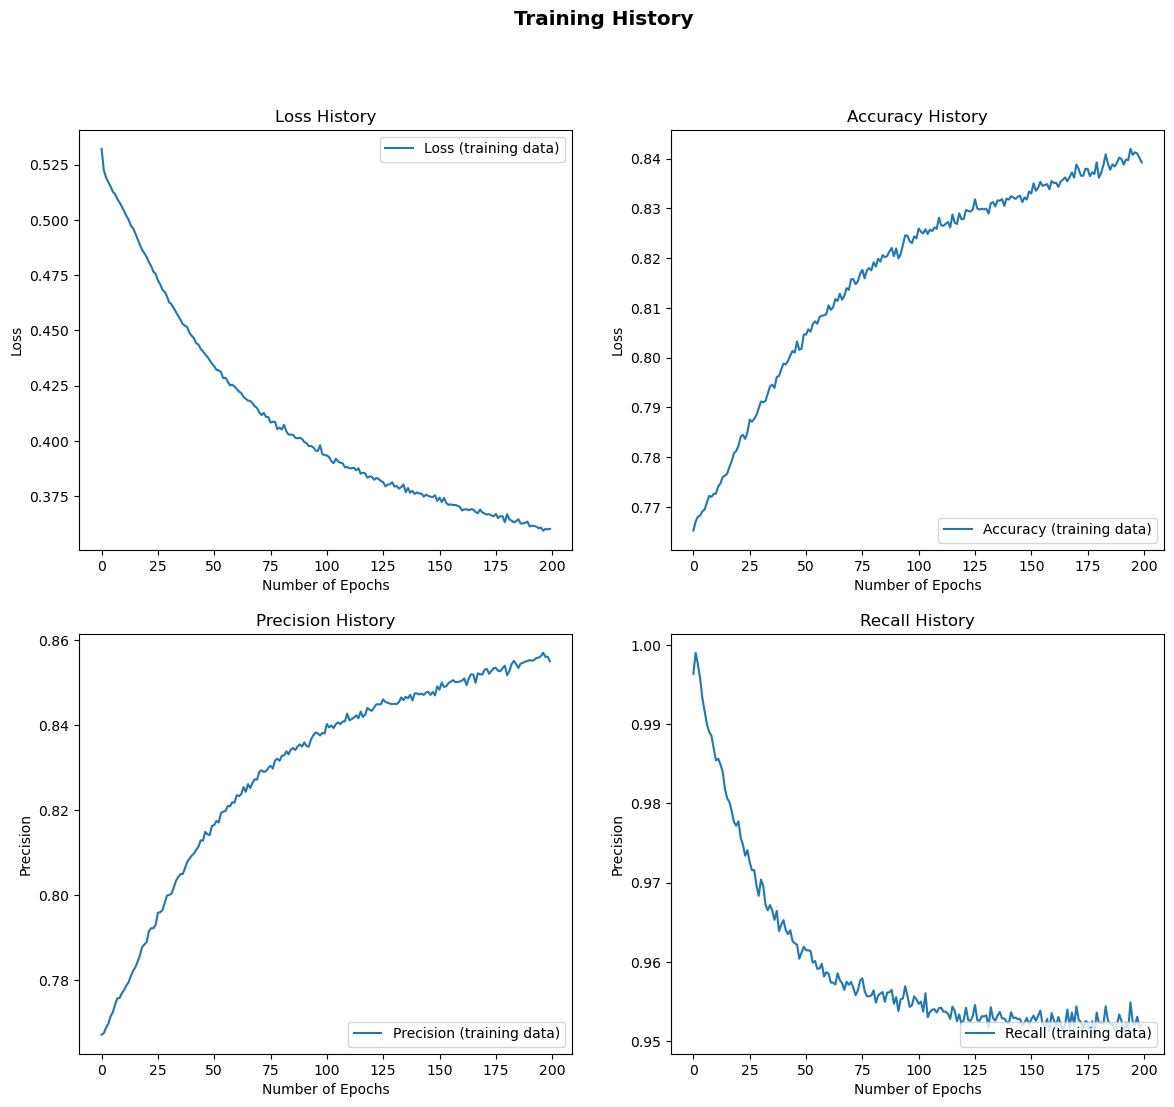

In [13]:
visualize_training_history(history)

Comparing train and test performances' accuracy metrics using confusion matrix:

1153/1153 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


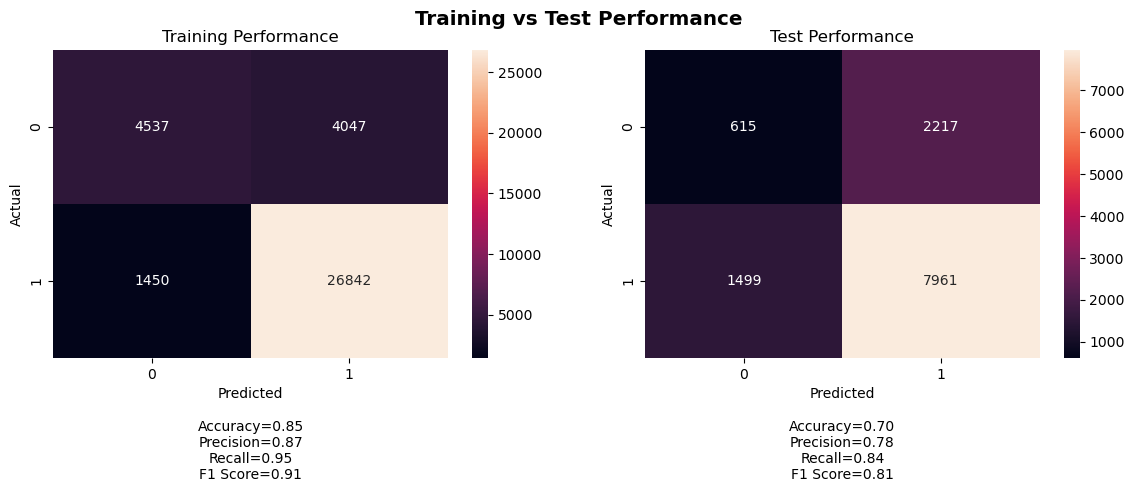

In [14]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Original', accuracy))
tests_performance['Test Precision'].append(('Original', precision))
tests_performance['Test Recall'].append(('Original', recall))
tests_performance['Test F1 Score' ].append(('Original', f1_score))

## SHapley Additive exPlanations
SHAP is used to explain the output of Machine Learning models. It is based on Shapley values, which use game theory to assign credit for a model’s prediction to each feature or feature value.

It decomposes the output of a model by the sums of the impact of each feature. SHAP calculates a value that represents the contribution of each feature to the model outcome. These values can be used to understand the importance of each feature.

Hence, we used it to analyse the importance of each variable in predicting the Loan Status, as well as correlation with the categories of Loan Status.

PermutationExplainer explainer: 36877it [59:36, 10.30it/s]                                                             


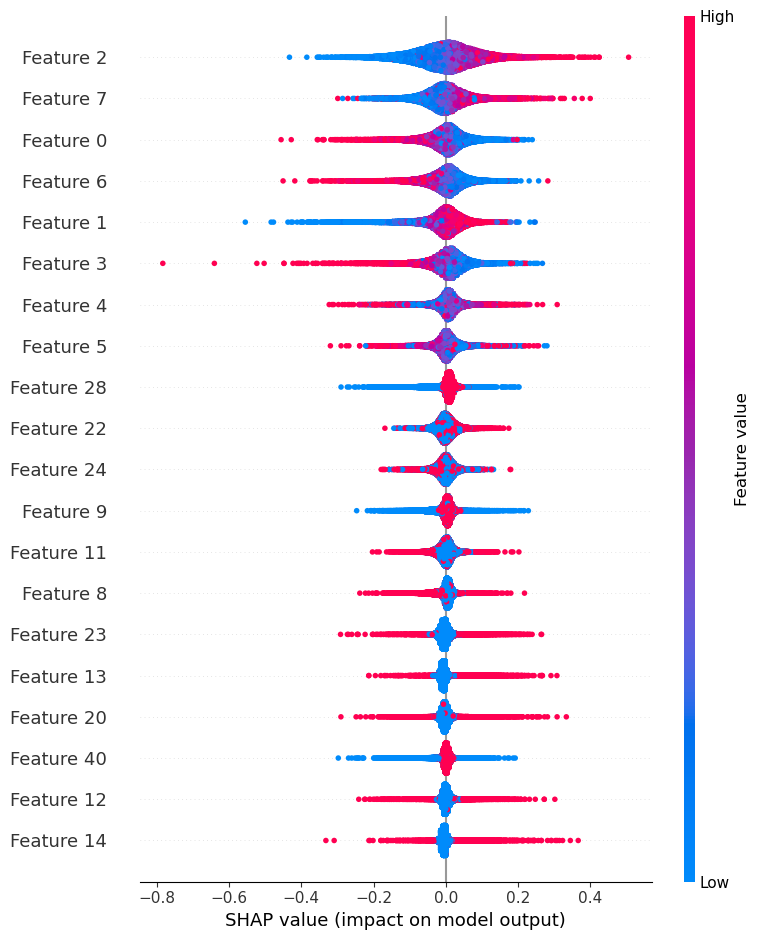

In [16]:
# Analyze model predictions and feature interactions
# For example, you can visualize feature importance, partial dependence plots, or SHAP values

# Example: SHAP (SHapley Additive exPlanations) values
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

Based on the graph:
> Feature 2 (Annual Income), Feature 7 (Maximum Open Credit)
- Mostly high with positive SHARP value
- Mostly low with negative SHARP value
- Higher value positively affects loan payment
> Feature 0 (Current Loan Amount), Feature 6 (Current Credit Balance)
- Mostly high with negative SHARP value
- Mostly low with positive SHARP value
- Higher value negatively affects loan payment